In [1]:
from SOH_func_scaler import *
import matplotlib.pyplot as pl
from keras import models, layers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

In [2]:
VERSION = 'FINAL_add' # 띄어쓰기 없이 어떤 모델인지 버전을 써주세요

FILE_00 = 'data_csv/CYCLE_CSV_data00.csv'
FILE_01 = 'data_csv/CYCLE_CSV_data01.csv'
FILE_02 = 'data_csv/CYCLE_CSV_data02.csv'
FILE_03 = 'data_csv/CYCLE_CSV_data03.csv'
FILE_04 = 'data_csv/CYCLE_CSV_data04.csv'
FILE_05 = 'data_csv/CYCLE_CSV_data05.csv'
FILE_06 = 'data_csv/CYCLE_CSV_data06.csv'

In [3]:
drop_labels_x = ['인덱스', '사이클_번호', '누적_용량(Ah)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
# 예측에 사용하지 않을 파라미터 목록

param = {'seq_len' : 30, 'num_units' : 64, 'num_filters' : 6, 'window' : 3, 'dropout': 0.1, 'num_epochs' : 2000, 'num_dense': 16}
# 모델 규격 지정 하이퍼파라미터

log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ.h5'
hist_freq = 250
# 텐서보드 설정(logs 폴더에 모델 학습 기록 저장)

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')
# 출력 저장 폴더 생성

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data00.csv => (475, 4)


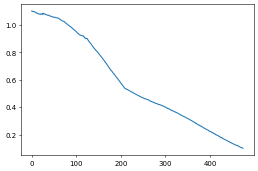

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data02.csv => (515, 4)


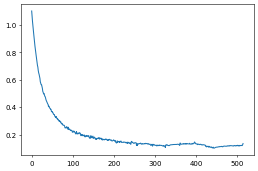

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data05.csv => (515, 4)


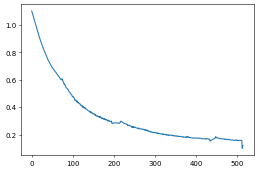

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data04.csv => (515, 4)


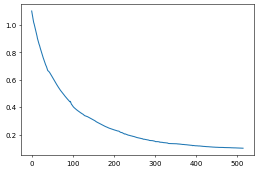

In [4]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
# data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data02, data_cap02 = get_data(FILE_02, drop_labels_x, drop_labels_y)
data04, data_cap04 = get_data(FILE_05, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_04, drop_labels_x, drop_labels_y)
# 쓸 데이터만 뽑아서 저장(입력 데이터, 정답 데이터)

In [5]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
# x_train01 = seq_gen_x(data01, param['seq_len'])
# y_train01 = seq_gen_y(data_cap01, param['seq_len'])
x_train02 = seq_gen_x(data02, param['seq_len'])
y_train02 = seq_gen_y(data_cap02, param['seq_len'])
x_train04 = seq_gen_x(data04, param['seq_len'])
y_train04 = seq_gen_y(data_cap04, param['seq_len'])
x_test = seq_gen_x(data_test, param['seq_len'])
y_test = seq_gen_y(data_cap_test, param['seq_len'])
print(x_train00.shape)
print(y_train00.shape)
# print(x_train00[0:5, :, 1])
# print(y_train00[:4])
# 시퀀스 단위로 쪼개기

(445, 30, 4)
(445, 1, 1)


In [6]:
inputs = layers.Input(shape=(param['seq_len'], x_train00.shape[-1]), name = 'Inputs')
x1 = layers.Conv1D(param['num_filters'], param['window'], padding='causal', name = 'Conv1D')(inputs)
x2 = layers.LSTM(param['num_units'], return_sequences = True, name = 'LSTM_sequence')(inputs)
x = layers.concatenate([x2, x1])
x = layers.LSTM(16, name = 'LSTM_add')(x)
x = layers.Dropout(param['dropout'], name = 'Dropout')(x)
outputs = layers.Dense(1, name = 'Outputs')(x)
model = models.Model(inputs = inputs, outputs = outputs, name = 'CNN_LSTM_PARALLEL')
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "CNN_LSTM_PARALLEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None, 30, 4)]      0           []                               
                                                                                                  
 LSTM_sequence (LSTM)           (None, 30, 64)       17664       ['Inputs[0][0]']                 
                                                                                                  
 Conv1D (Conv1D)                (None, 30, 6)        78          ['Inputs[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 30, 70)       0           ['LSTM_sequence[0][0]',          
                                                                  'Conv1D[0][0]'] 

In [7]:
BATCH_SIZE = 128
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
# callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
#                  TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
# fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train02, y_train02, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train04, y_train04, epochs=param['num_epochs'], verbose = 2, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callback_list)

Epoch 1/2000
3/3 - 13s - loss: 0.7236 - val_loss: 0.0036 - 13s/epoch - 4s/step
Epoch 2/2000
3/3 - 0s - loss: 0.1502 - val_loss: 0.0192 - 77ms/epoch - 26ms/step
Epoch 3/2000
3/3 - 0s - loss: 0.0571 - val_loss: 0.0718 - 70ms/epoch - 23ms/step
Epoch 4/2000
3/3 - 0s - loss: 0.1001 - val_loss: 0.0712 - 75ms/epoch - 25ms/step
Epoch 5/2000
3/3 - 0s - loss: 0.0781 - val_loss: 0.0428 - 67ms/epoch - 22ms/step
Epoch 6/2000
3/3 - 0s - loss: 0.0419 - val_loss: 0.0213 - 74ms/epoch - 25ms/step
Epoch 7/2000
3/3 - 0s - loss: 0.0414 - val_loss: 0.0109 - 71ms/epoch - 24ms/step
Epoch 8/2000
3/3 - 0s - loss: 0.0430 - val_loss: 0.0066 - 70ms/epoch - 23ms/step
Epoch 9/2000
3/3 - 0s - loss: 0.0366 - val_loss: 0.0053 - 67ms/epoch - 22ms/step
Epoch 10/2000
3/3 - 0s - loss: 0.0285 - val_loss: 0.0053 - 65ms/epoch - 22ms/step
Epoch 11/2000
3/3 - 0s - loss: 0.0258 - val_loss: 0.0057 - 118ms/epoch - 39ms/step
Epoch 12/2000
3/3 - 0s - loss: 0.0199 - val_loss: 0.0056 - 73ms/epoch - 24ms/step
Epoch 13/2000
3/3 - 0s - l

16/16 [==============================] - 0s 5ms/step
(485, 1)
outputs\FINAL_add\6FL-64UN-2000EP-30SQ


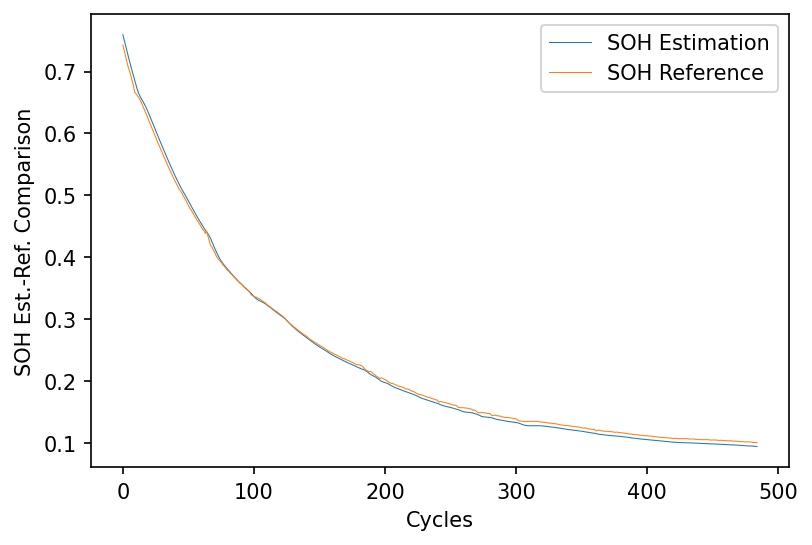

In [8]:
RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

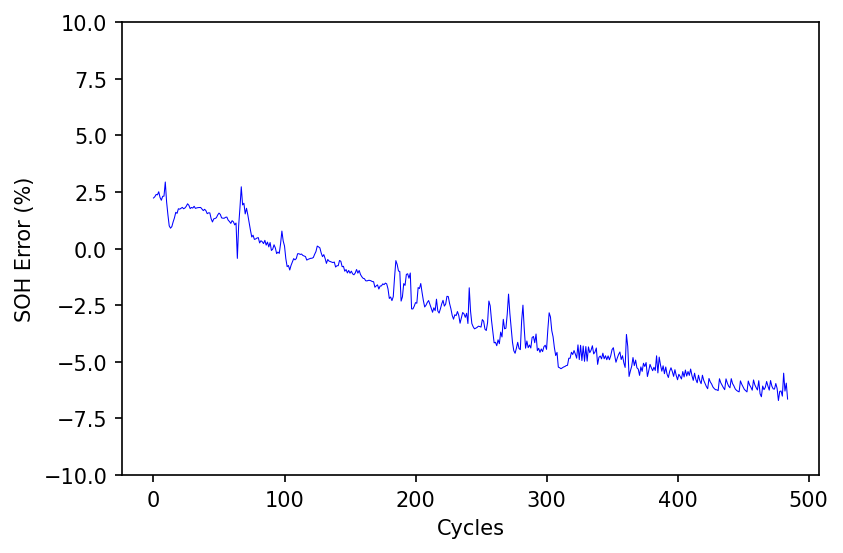

RMSE(0.006097), MAE(0.005406)


In [9]:
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOH Error (%)')
pl.xlabel('Cycles')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\\ErrRate-RMSE({RMSE:.4f})MAE({MAE:.4f}).png')
pl.show()
print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')